# Sagemaker JumpStart + HuggingFace Embeddings + Langchain

## This is a Level 200 Instructor Led Lab

## Acknowledgement

This notebook is based off: https://github.com/gkamradt/langchain-tutorials

This notebook has been modified for the purpose of providing guided instructor led Level-200 coding experience to those with limited AI/ML and Jupyter notebook experience. The notebook refers to education material to explain concepts to make it easier for the audience. The code is assimilated from various aws-sample repositories. 

**let's get started...**

## Part 0 - Set Up Your Jupyter notebook

### 00a. Set Kernel for your Jupyter notebook

### For this Sagemaker Studio notebook, we will be using the following:
- instance: ml.g4dn.xlarge
- kernel: python 3
- pyTorch 1.13 Python 3.9 GPU Optimised

### Follow instructions provided in your lab to set up the Jupyter notebook kernel...
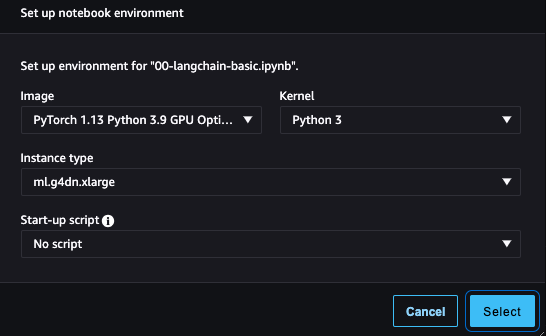

***<span>Important - failure to set the right kernel will result in errors during execution of the Jupyter notebook cells</span>***

### Sagemaker Studio uses Jupyter notebooks
Jupyter notebooks use Python. Python is an interpretter language i.e. it does not need to be compiled. The Jupyter notebook has cells. Each cell can be executed independly and shares the same runtime memory, so any variables set can be used across the notebook. The format of the notebook allows for experimentation on the fly...  

### 00b. Update SageMaker LLM Endpoint Name

We will leverage the jumpstart-dft-falcon-7b-instruct-bf16 model you deployed directly using SageMaker JumpStart

- jumpstart-dft-falcon-7b-instruct-bf16

Update this configuration section to replace the value of 'endpoint_name' with the name of your deployed model

In [2]:
_MODEL_CONFIG_ = {
    
    "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16" : {
        "aws_region": "us-east-1",
        "endpoint_name": "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"
    },
}

## Part 1 - Set Up

### 01a. Lab Overview


## What is LangChain?
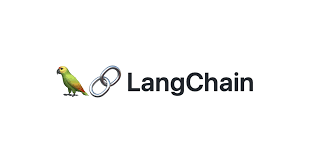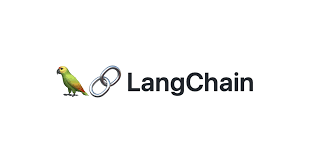

LangChain is a framework for developing applications powered by language models. 

**LLMs are powerful by themselves. Why do we need libraries like LangChain?**
LangChain provides a level of abstraction, making it super easy to use. LangChain's popularity has grown exponentially since it was first introduced and being an open source library, it is constantly evolving!

### 01b. Set up workshop dependencies

In [3]:
!pip install --upgrade -q pip
!pip install --upgrade -q langchain
!pip install -q transformers
!pip install -q faiss-gpu
!pip install -q bs4
!pip install -q sentence-transformers
!pip install sentence_transformers
#!pip install --upgrade --no-cache --force-reinstall -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server-proxy 4.0.0 requires simpervisor>=0.4, which is not installed.


In [4]:
import langchain

print(langchain.__version__)
# assert int(langchain.__version__.split(".")[-1]) >= 194

0.0.236


### 01c. Initialize text artifacts that we will use in this lab

In this hands-on lab, we will experiment with multiple text artifacts, like text, documents, chat messages.

### Text

In [5]:
# You'll be working with simple strings (that'll soon grow in complexity!)
my_text = "What day comes after Friday?"

### Documents

In [6]:
# loading the required libraries
from langchain.schema import Document

# we will load the LangChain Papers as an example 
Document(page_content="This is my document. It is full of text that I've gathered from other places",
         metadata={
             'my_document_id' : 234234,
             'my_document_source' : "The LangChain Papers",
             'my_document_create_time' : 1680013019
         })

Document(page_content="This is my document. It is full of text that I've gathered from other places", metadata={'my_document_id': 234234, 'my_document_source': 'The LangChain Papers', 'my_document_create_time': 1680013019})

### Chat Messages

In [7]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [8]:
# SystemMessage and HumanMessage are wrappers around Prompts being sent to the deployed LLM models
# SystemMessage - Provides instruction to the LLM model on how we expect it to behave
# HumanMessage - not required, but helps seed the LLM model on what it could expect
[
    SystemMessage(content="You are a nice AI bot that helps a user figure out what to eat in one short sentence"),
    HumanMessage(content="I like tomatoes, what should I eat?")
]

[SystemMessage(content='You are a nice AI bot that helps a user figure out what to eat in one short sentence', additional_kwargs={}),
 HumanMessage(content='I like tomatoes, what should I eat?', additional_kwargs={}, example=False)]

## Part 2 - Initialize the LangChain library with your deployed model endpoint

In [9]:
import json
from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

# These are hyper-parameters; Hyperparameters are used before inferencing a model because they have a
# direct impact on the performance of the resulting machine learning model. 
# Hyperparameters are used before inferencing a model because they control the behavior of the model, 
# and optimize its performance for the job at hand.
# For this workshop, hyper parameters have been identified for you...  
parameters ={
        "max_new_tokens": 100,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": False,
        "temperature": 0.2
}

# A function that helps handle the JSON messages going in and out of the LLM 
class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"inputs": prompt, "parameters": model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json[0]["generated_text"]


content_handler = ContentHandler()

# Passing the SagemakerEndPoint to LangChain so that it knows where to send all the inference requests
sm_llm_falcon_instruct = SagemakerEndpoint(
    endpoint_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["aws_region"],
    model_kwargs=parameters,
    content_handler=content_handler,
)

In [10]:
# testing our Sagemaker JumpStart inference end point with a simple message to the LLM, through LangChain
sm_llm_falcon_instruct("What day comes after Friday?")

'\nThe day after Friday is Saturday.'

## Part 3 - Understand text embeddings & see semantic search in action

In [15]:
!pip install sentence_transformers
!pip install transformers -U

INFO: Successfully saved requirements file in /root/CAT_Immersion_Day_Labs/langchain_falcon_internal_lab_from_bc/requirements.txt


In [ ]:
# Initialize the Huggingface Embeddings Model
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings()

In [ ]:
text = "Hi! It's time for the beach"

text_embedding = embeddings.embed_query(text)
print (f"Your embedding is length {len(text_embedding)}")
print (f"Here's a sample: {text_embedding[:5]}...")

In [ ]:
doc_embedding = embeddings.embed_documents([text])
print (f"Your embedding is length {len(doc_embedding[0])}")
print (f"Here's a sample: {doc_embedding[0][:5]}...")

In [ ]:
from sklearn.preprocessing import normalize
import seaborn as sns
import numpy as np

def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")
    
sentences = [
    # Pets
    "Your koala is really cute.",
    "How cute your koala is!",
    "You have such a cute koala!",
    # Location
    "Melbourne is the place where I work and live.",
    "I work and live in Melbourne.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

doc_emb = embeddings.embed_documents(sentences)
plot_similarity_heatmap(
    sentences, normalize(
    np.array(doc_emb), axis=1), 
    90
)

## Part 4 - Experiment with prompt and prompt templates

In [ ]:
prompt = """
Today is Monday, tomorrow is Wednesday.

What is wrong with that statement?
"""

sm_llm_falcon_instruct(prompt)

### Prompt Template

In [ ]:
from langchain import PromptTemplate

# Notice "location" below, that is a placeholder for another value later
template = """
I want to travel to {location}. What should I do there?

Respond in 300 words
"""

prompt = PromptTemplate(
    input_variables=["location"],
    template=template,
)

final_prompt = prompt.format(location='NY')

print (f"Final Prompt: {final_prompt}")
print ("-----------")
print (f"LLM Output: {sm_llm_falcon_instruct(final_prompt)}")

## Part 5 - Experiment with vector databases and few shot prompting

In [ ]:
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.vectorstores import FAISS
from langchain.prompts import FewShotPromptTemplate, PromptTemplate


example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

# Examples of locations that nouns are found
examples = [
    {"input": "pirate", "output": "ship"},
    {"input": "pilot", "output": "plane"},
    {"input": "driver", "output": "car"},
    {"input": "tree", "output": "ground"},
    {"input": "bird", "output": "nest"},
]

In [ ]:
# SemanticSimilarityExampleSelector will select examples that are similar to your input by semantic meaning

example_selector = SemanticSimilarityExampleSelector.from_examples(
    # This is the list of examples available to select from.
    examples, 
    
    # This is the embedding class used to produce embeddings which are used to measure semantic similarity.
    embeddings, 
    
    # This is the VectorStore class that is used to store the embeddings and do a similarity search over.
    FAISS, 
    
    # This is the number of examples to produce.
    k=2
)

In [ ]:
similar_prompt = FewShotPromptTemplate(
    # The object that will help select examples
    example_selector=example_selector,
    
    # Your prompt
    example_prompt=example_prompt,
    
    # Customizations that will be added to the top and bottom of your prompt
    prefix="Give the location an item is usually found in",
    suffix="Input: {noun}\nOutput:",
    
    # What inputs your prompt will receive
    input_variables=["noun"],
)

In [ ]:
# Select a noun!
my_noun = "students"
#my_noun = "flower"

print(similar_prompt.format(noun=my_noun))

In [ ]:
sm_llm_falcon_instruct.model_kwargs ={
        "max_new_tokens": 5,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": False,
        "temperature": .2,
        "stop": ["Input", "\n"]
}
sm_llm_falcon_instruct(similar_prompt.format(noun=my_noun))

## Part 6 - Experiment with Output Parsers

1. **Format Instructions** - A autogenerated prompt that tells the LLM how to format it's response based off your desired result
2. **Parser** - A method which will extract your model's text output into a desired structure (usually json)

#### No Formatting

In [ ]:
sm_llm_falcon_instruct.model_kwargs ={
        "max_new_tokens": 100,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": False,
        "temperature": .2,
        # "stop": ["Input", "\n"]
}

In [ ]:
prompt = PromptTemplate(
    template="""You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly

% USER INPUT:
{user_input}

YOUR RESPONSE:""",
    input_variables=["user_input"],
)

output = sm_llm_falcon_instruct(prompt.format(user_input="welcom to dilhi!"))
output

In [ ]:
# let's try another example...
output = sm_llm_falcon_instruct(prompt.format(user_input="Anna an Mike is goin sking. We enjoys horror movies."))
output

## Part 7 - Experiment with Documents

In [ ]:
from langchain.document_loaders import HNLoader

In [ ]:
loader = HNLoader("https://news.ycombinator.com/item?id=34422627")
data = loader.load()

print (f"Found {len(data)} comments")
print (f"Here's a sample:\n\n{''.join([x.page_content[:150] for x in data[:2]])}")

### Text Splitter - Works!

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# This is a long document we can split up.
with open('Amazon_SageMaker_FAQs.txt') as f:
    pg_faq = f.read()
    
print (f"You have {len([pg_faq])} document")

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 300,
    chunk_overlap  = 50,
)

texts = text_splitter.create_documents([pg_faq])

In [ ]:
print (f"You have {len(texts)} documents")

In [ ]:
print ("Preview:")
print (texts[0].page_content, "\n")
print (texts[1].page_content)

### Retrievers

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

loader = TextLoader('Amazon_SageMaker_FAQs.txt')
documents = loader.load()

In [ ]:
# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

# Split your docs into texts
texts = text_splitter.split_documents(documents)

# Get embedding engine ready
embeddings

# Embedd your texts
db = FAISS.from_documents(texts, embeddings)

In [ ]:
# Init your retriever. Asking for just 1 document back
retriever = db.as_retriever()
retriever

In [ ]:
docs = retriever.get_relevant_documents("Which instance is supported for spot training?")
print("\n\n".join([x.page_content for x in docs[:3]]))

### VectorStores

In [ ]:
print (f"You have {len(texts)} documents")

## Part 8 - Experiment with various chains from LangChain

In [ ]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SimpleSequentialChain

In [ ]:
parameters = {
    "max_new_tokens": 1500,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 1,
    "seed": 123
}

sm_llm_falcon_instruct.model_kwargs = parameters

In [ ]:
template = """Your job is to come up with a classic dish from the area that the users suggests.
% USER LOCATION
{user_location}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_location"], template=template)

# Holds my 'location' chain
location_chain = LLMChain(llm=sm_llm_falcon_instruct, prompt=prompt_template)


In [ ]:
template = """Given a meal, give a short and simple recipe on how to make that dish at home.
% MEAL
{user_meal}

YOUR RESPONSE:
"""
prompt_template = PromptTemplate(input_variables=["user_meal"], template=template)

# Holds my 'meal' chain
meal_chain = LLMChain(llm=sm_llm_falcon_instruct, prompt=prompt_template)

In [ ]:
overall_chain = SimpleSequentialChain(chains=[location_chain, meal_chain], verbose=True)
review = overall_chain.run("Paris")

In [ ]:
review = overall_chain.run("Lahore")

### Summarization Chain


In [ ]:
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = TextLoader('Amazon_SageMaker_FAQs.txt')
documents = loader.load()

# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=5)

# Split your docs into texts
texts = text_splitter.split_documents(documents)
len(texts)

In [ ]:
parameters = {
    "max_new_tokens": 100,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 1,
}

sm_llm_falcon_instruct.model_kwargs = parameters

In [ ]:
# There is a lot of complexity hidden in this one line of code that is triggering chain_type="map_reduce" 
# Map Reduce applies an initial prompt to each chunk of data. 
# This is then passed through the language model to generate multiple responses. 
# Another prompt is created to combine all of the initial outputs into one. 
# This technique requires more than one call to the LLM.
chain = load_summarize_chain(sm_llm_falcon_instruct, chain_type="map_reduce", verbose=True)
chain.run(texts[:2])

### Chat

In [ ]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain import PromptTemplate

memory = ConversationBufferMemory(return_messages=True)
memory.chat_memory.add_user_message("I'm visting Sydney Australia, what should I have for dinner there?\n\n")
memory.chat_memory.add_ai_message("Sydney has lot of nice food, Visit China town maybe.\n\n")
memory.load_memory_variables({})

In [ ]:
parameters = {
    "max_new_tokens": 200,
    "num_return_sequences": 1,
    "top_k": 250,
    "top_p": 0.95,
    "do_sample": False,
    "temperature": 0.7,
    "stop": ["\n"]
}

sm_llm_falcon_instruct.model_kwargs = parameters

conversation = ConversationChain(
    llm=sm_llm_falcon_instruct, verbose=False, memory=memory,
    prompt = PromptTemplate(template="""
    You are a nice AI bot that helps a user figure out what to eat in one short sentence.
    
    Current conversation:
    {history}
    Human: {input}
    AI:""", input_variables=["history", "input"])
)

In [ ]:
conversation.run("What about Delhi?")

## Experimenting with Agents

In [ ]:
from langchain.utilities import PythonREPL
python_repl = PythonREPL()
python_repl.run("print(17*2)")

In [ ]:
!pip -q install wikipedia
from langchain.utilities import WikipediaAPIWrapper
wikipedia = WikipediaAPIWrapper()
wikipedia.run('Langchain')

In [ ]:
!pip -q install duckduckgo-search
from langchain.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()
search.run("Tesla stock price?")

In [ ]:
from langchain.agents.tools import Tool
tools = [Tool(
        name = "python repl",
        func=python_repl.run,
        description="useful for when you need to use python to answer a question. You should input python code"
    )
]

In [ ]:
wikipedia_tool = Tool(
    name='wikipedia',
    func= wikipedia.run,
    description="Useful for when you need to look up a topic, country or person on wikipedia"
)

duckduckgo_tool = Tool(
    name='DuckDuckGo Search',
    func= search.run,
    description="Useful for when you need to do a search on the internet to find information that another tool can't find. be specific with your input."
)

In [ ]:
tools.append(duckduckgo_tool)
tools.append(wikipedia_tool)


In [ ]:
from langchain.agents import initialize_agent

zero_shot_agent = initialize_agent(
    agent="zero-shot-react-description", 
    tools=tools, 
    llm=sm_llm_falcon_instruct,
    verbose=True,
    max_iterations=3,
)

In [ ]:
zero_shot_agent.run("When was Barak Obama born?")

## Part 9 - Cleanup

- No code here because we will leverage the deployed Sagemaker LLM Endpoint in the next lab as well
- If you are not planning to do the next lab, you should go back to Sagemaker Console > Inference > Endpoints and manually delete your model endpoint to avoid any charges


In [ ]:
!pipreqs --force